In [1]:
using Graphs
using Plots
using LinearAlgebra
include("../inference/zero_patient.jl")
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [2]:
q = q_sis
T = 5
N = 20
k = 3
gg = random_regular_graph(N, k)
g = IndexedGraph(gg)
λ = 0.1
κ = 0.08
p⁰ = map(1:N) do i
    p_infected = 3/N
    [1-p_infected, p_infected]
end
sis = SIS(g, λ, κ, T; p⁰);

In [3]:
function sis_compare_bp_mc(T::Integer, N::Integer, λ::Real, κ::Real, γ::Real,
        nobs::Integer; softinf=1e2, nsamples_mc=10^5)
    
    gg = random_regular_graph(N, 3)
    g = IndexedGraph(gg)
    p⁰ = fill([1-γ, γ], N)
    sis = SIS(g, λ, κ, T; p⁰)
    X, bp = simulate_sis(g, λ, κ, p⁰, T, nobs; softinf)
    true_zp = findall(isequal(I), X[:,1]) 
    id_bp, b⁰_bp = find_zero_patients_bp(bp)
    id_mc, b⁰_mc, sms = find_zero_patients_mc(bp; nsamples=nsamples_mc)
    auc_bp = round(auc(id_bp, true_zp), digits=4)
    auc_mc = round(auc(id_mc, true_zp), digits=4)
    
    return auc_bp, auc_mc
end

sis_compare_bp_mc (generic function with 1 method)

In [4]:
nobs = 10
softinf = 1e2
X, bp = simulate_sis(g, λ, κ, p⁰, T, nobs; softinf);

In [5]:
true_zp = findall(isequal(I), X[:,1]) 

Int64[]

In [6]:
@time begin
    id_bp, b⁰_bp = find_zero_patients_bp(bp)
end
b_bp = beliefs(bp)
[id_bp b⁰_bp][1:10,:]

Running MPdBP: iter 7 	 Time: 0:00:28
  Δ:  0.0007941039163844588

 37.012661 seconds (57.94 M allocations: 3.928 GiB, 7.66% gc time, 85.08% compilation time)


10×2 Matrix{Float64}:
 10.0  0.129256
  9.0  0.129026
 20.0  0.111839
  5.0  0.105721
 16.0  0.105693
 15.0  0.105241
 18.0  0.103826
 14.0  0.101334
  8.0  0.0977904
  4.0  0.0977898

In [7]:
nsamples = 10^5
@time begin
    id_mc, b⁰_mc, sms = find_zero_patients_mc(bp; nsamples)
end
b_mc = marginals(sms)
[id_mc [b.val for b in b⁰_mc]][1:10,:]

SoftMargin sampling... 100%|█████████████████████████████| Time: 0:00:08


 10.854694 seconds (65.01 M allocations: 3.291 GiB, 12.12% gc time, 22.08% compilation time)


10×2 Matrix{Float64}:
  9.0  0.130532
 10.0  0.128367
 16.0  0.112606
 20.0  0.112522
 15.0  0.107813
  5.0  0.105697
 18.0  0.103732
 14.0  0.101986
  8.0  0.100634
  4.0  0.10035

SIS on random regular graph N=20, k=3. P(S→I)=0.1, P(I→S)=0.08.


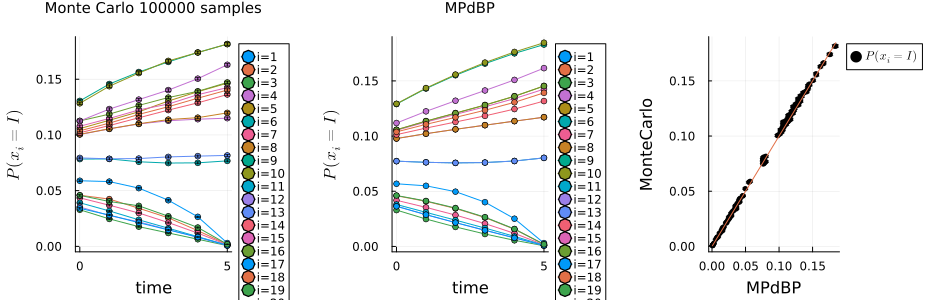

In [8]:
p_bp = [[bbb[2] for bbb in bb] for bb in b_bp]
p_mc = [[bbb[2] for bbb in bb] for bb in b_mc]
pl_mc = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:5:T, title="Monte Carlo $nsamples samples")
for i in 1:N
    plot!(pl_mc, 0:T, p_mc[i], label="i=$i", m=:o, ms=3, lw=1)
end
pl_bp = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:5:T, title="MPdBP")
for i in 1:N
    plot!(pl_bp, 0:T, p_bp[i], label="i=$i", m=:o, ms=3, lw=1)
end
pl_sc = scatter(reduce(vcat, p_bp), reduce(vcat, p_mc), xlabel="MPdBP", ylabel="MonteCarlo", 
    label="\$P(x_i=I)\$", ms=3, c=:black, legend=:outertopright)
plot!(identity, label="", size=(300,300))
println("SIS on random regular graph N=$N, k=$k. P(S→I)=$λ, P(I→S)=$κ.")
# println("$nobs_node random node observations, $nobs_edge random edge observations")
# println("Max matrix size: ", svd_trunc.mprime, "x", svd_trunc.mprime)
plot(pl_mc, pl_bp, pl_sc, titlefontsize=10, size=(950, 300), legend=:outertopright, 
    margin=5Plots.mm, layout=(1,3))

In [9]:
auc_bp = round(auc(id_bp, true_zp), digits=4)
auc_mc = round(auc(id_mc, true_zp), digits=4);

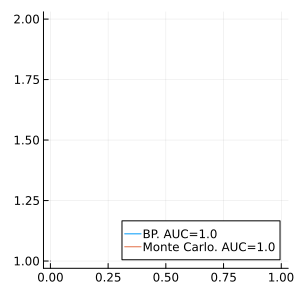

In [10]:
pl_roc = plot(roc(id_bp, true_zp)..., st=:steppre, label="BP. AUC=$auc_bp")
plot!(pl_roc, roc(id_mc, true_zp)..., st=:steppre, label="Monte Carlo. AUC=$auc_mc")
plot(pl_roc, size=(300,300), legend=:bottomright)

In [27]:
T = 5
N = 30
k = 3
gg = random_regular_graph(N, k)
g = IndexedGraph(gg)
λ = 0.1
κ = 0.08
γ = 3/N
nsamples_mc = 3*10^5;

In [28]:
ProgressMeter.ijulia_behavior(:append)
nobss = [2, 5, 10, 15, 20]
aucs_bp = [zeros(0) for _ in nobss]
aucs_mc = [zeros(0) for _ in nobss];

In [ ]:
ninstances = 100
for (i, nobs) in enumerate(nobss)
    println("### $nobs observations ###")
    for a in 1:ninstances
        ab, am = sis_compare_bp_mc(T, N, λ, κ, γ, nobs; nsamples_mc)
        push!(aucs_bp[i], ab)
        push!(aucs_mc[i], am)
    end
end

### 2 observations ###


Running MPdBP: iter 2 	 Time: 0:00:00
  Δ:  26.26280305526524

In [ ]:
aucs_bp_avg = mean.(aucs_bp)
aucs_bp_std = std.(aucs_bp) ./ sqrt(length(aucs_bp[1]))
aucs_mc_avg = mean.(aucs_mc)
aucs_mc_std = std.(aucs_mc) ./ sqrt(length(aucs_mc[1]))
println("SIS with: P(S→I)=λ=$λ, P(I→S)=κ=$κ. P(zero patient)=γ=$γ")
println("Random regular N=$N, k=3. T=$T, random observations from the prior at final time")
plot(nobss, aucs_bp_avg, m=:o, ribbon=aucs_bp_std, label="bp", legend=:bottomright)
plot!(nobss, aucs_mc_avg, m=:o, ribbon=aucs_mc_std, label="mc", xlabel="number of obs", ylabel="AUC")

In [ ]:
savefig("zeropatient.pdf")